In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../data/prep.xlsx', header=None)

In [3]:
data.columns = ['Sample','CellType','Values','Unit','Test']

In [4]:
data = data.dropna().reset_index(drop=True)

In [5]:
data['Conditions'] = data['Sample'].apply(lambda x: 'Veh' if x.startswith('C')
                     else ('D1' if x.startswith('V')
                           else ('D2' if x.startswith('Drug 2') else ('D3' if x.startswith('Drug 3') else 'Ctr'))))

In [6]:
data.Conditions = data.Conditions.astype('category').cat.reorder_categories(['Ctr','Veh','D1','D2','D3'])

In [7]:
data['CT_unit'] = data.CellType.astype(str) + ' ' + data.Unit.astype(str)

In [8]:
datas = {k:data[data.CellType == k].reset_index(drop=True) for k in data.CellType.unique()}

In [9]:
import seaborn as sns
from scipy import stats

In [10]:
list(sns.color_palette("Set2", 5).as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

In [11]:
stats.normaltest(datas['Erythrocytes'].Values)

NormaltestResult(statistic=6.559683132736627, pvalue=0.03763421886083863)

In [12]:
for c in ['Veh','Ctr']:
    t = ['D1','D2','D3']
    if c == 'Ctr':
        t = t[1:]
    for i in t:
        a = datas['Thrombocytes'][datas['Thrombocytes'].Conditions == c].Values
        b = datas['Thrombocytes'][datas['Thrombocytes'].Conditions == i].Values
        print(c,i,stats.ttest_ind(a,b)[1]/5)

Veh D1 0.07167546266053315
Veh D2 0.060551052353791136
Veh D3 0.023764909595183382
Ctr D2 0.08743360439236561
Ctr D3 0.04428250808884499


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_78557/1291553095.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Ctr','Veh','V','P Bcl-2','P Bcl-xL'], fontsize=12, rotation=90)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_78557/1291553095.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_78557/1291553095.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Ctr','Veh','V','P Bcl-2','P Bcl-xL'], fontsize=12, rotation=90)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn

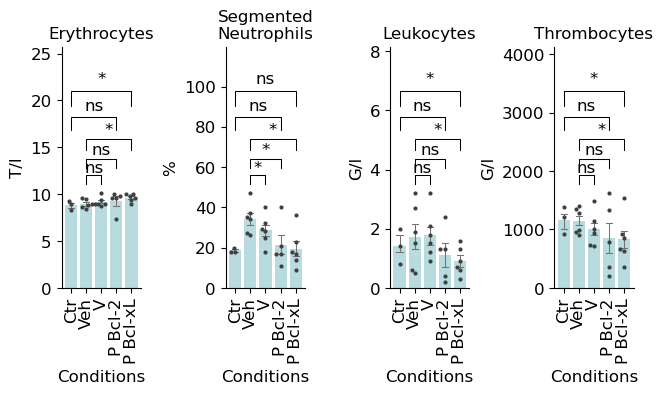

In [54]:
fig, axes = plt.subplots(1,4,figsize=(4.3*1.5,3))
axes = axes.ravel()
fig.tight_layout(w_pad=3, h_pad=3.5)
for ax,k,v in zip(axes,
                  ['Erythrocytes','Segmented neutrophils','Leukocytes','Thrombocytes'],
                  list(map(datas.get,['Erythrocytes','Segmented neutrophils','Leukocytes','Thrombocytes']))):
    # if k in ['Erythrocytes','Segmented neutrophils','Leukocytes','Thrombocytes']:
        tests = []
        bon_fact = 0
        for c in ['Veh','Ctr']:
            t = ['D1','D2','D3']
            if c == 'Ctr':
                t = t[1:]
            for i in t:
                a = v[v.Conditions == c].Values
                b = v[v.Conditions == i].Values
                tests.append(stats.ttest_ind(a,b)[1])
                bon_fact += 1
        tests = [i/bon_fact for i in tests] # correction for multiple hypothesis testing
        sns.barplot(x='Conditions', y='Values', data=v, errorbar=("ci", 68),
                    capsize=.4,err_kws={"color": "0.45", "linewidth": 0.75}, ax=ax, color='#b0e0e6')
        sns.swarmplot(x='Conditions', y='Values', data=v, ax=ax, color='0.25', size=3)
        
        max_val = v.Values.max() + v.Values.max()*0.1
        to = 2
        for num in range(3):
            ax.plot([1,1,to,to], [max_val, max_val+max_val*0.08, max_val+max_val*0.08, max_val], lw=0.75, c='k')
            ax.text((1+to)/2, max_val+max_val*0.15, '*' if tests[num] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
            max_val = max_val + max_val*0.15
            to += 1
        
        to = 3
        for num in range(2):
            ax.plot([0,0,to,to], [max_val, max_val+max_val*0.08, max_val+max_val*0.08, max_val], lw=0.75, c='k')
            ax.text((0+to)/2, max_val+max_val*0.15, '*' if tests[num+3] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
            max_val = max_val + max_val*0.15
            to += 1    

        ax.set_xlabel('Conditions', fontsize=12)
        ax.set_ylabel(v.Unit.unique()[0], fontsize=12)
        ax.set_ylim(0, max_val+max_val*0.15)
        ax.set_xticklabels(['Ctr','Veh','V','P Bcl-2','P Bcl-xL'], fontsize=12, rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        ax.set_title('\n'.join(k.title().split(' '))
                     if ' ' in k else k.title(), fontsize=12)
        for spine in ['top','right']:
            ax.spines[spine].set_visible(False)
fig.savefig(f'../plots/blood_manu.pdf', dpi=300, bbox_inches='tight')

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/2826604869.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/2826604869.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/2826604869.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/2826604869.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/2826604869.py:39: UserWarning: FixedFormatter should only be used together with Fixe

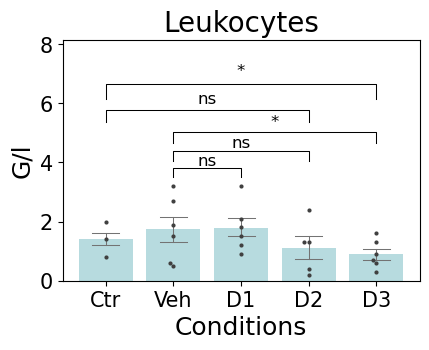

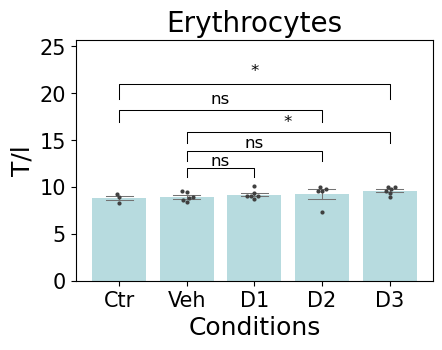

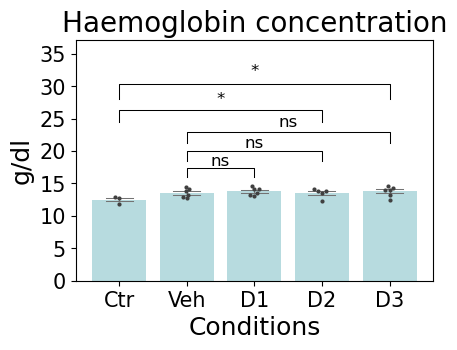

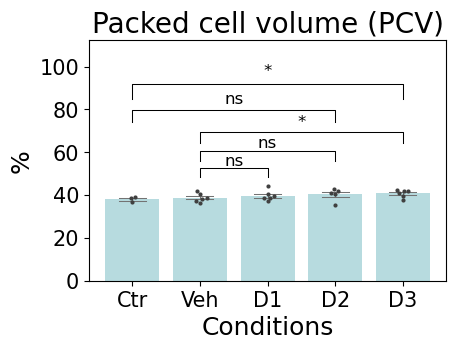

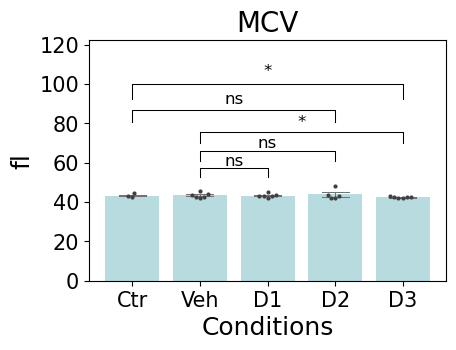

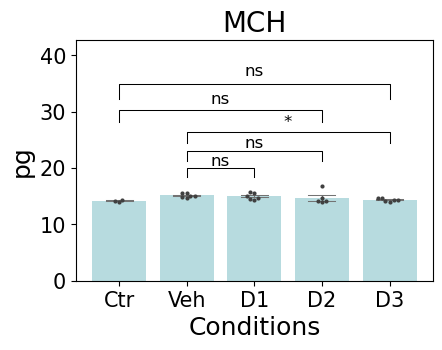

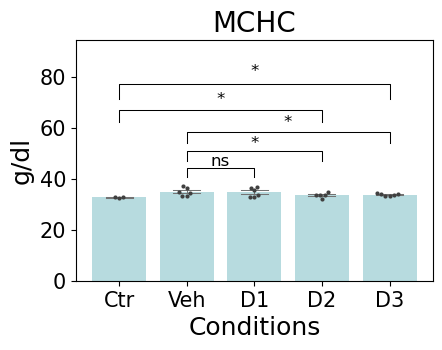

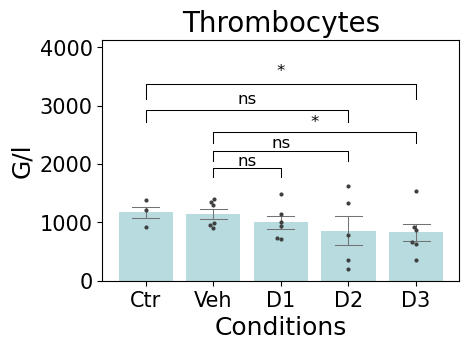

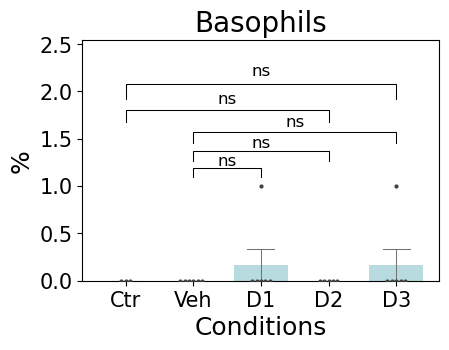

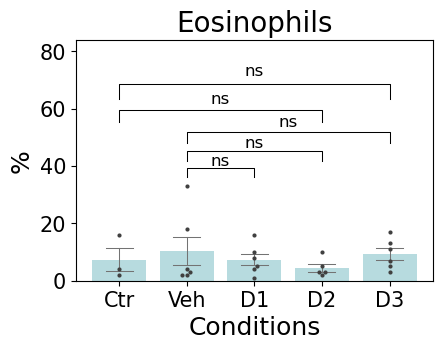

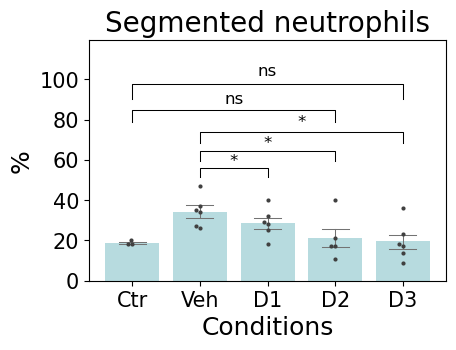

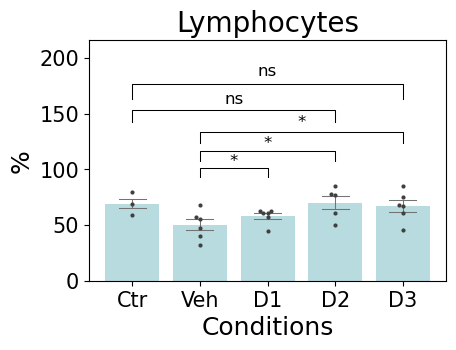

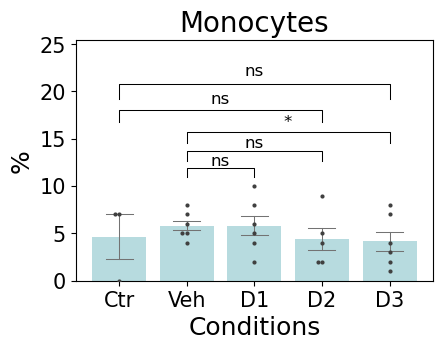

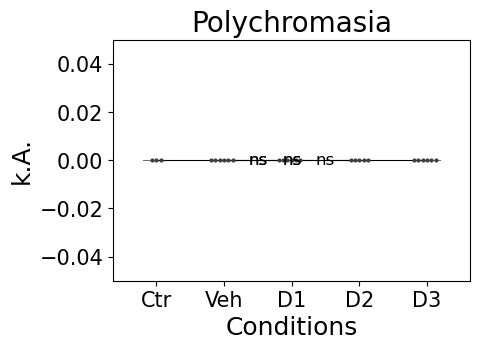

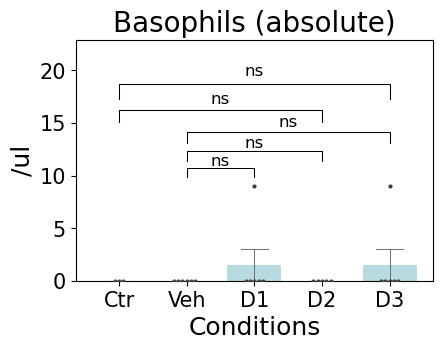

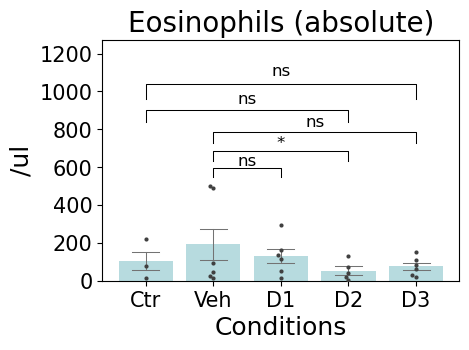

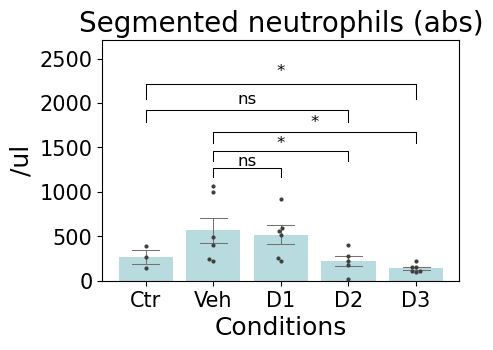

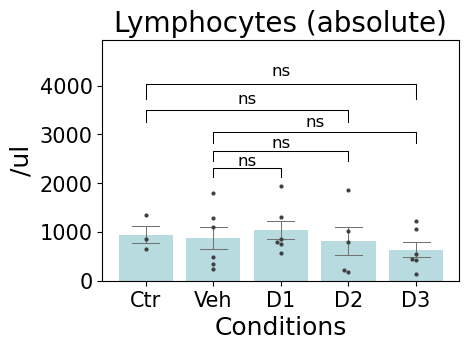

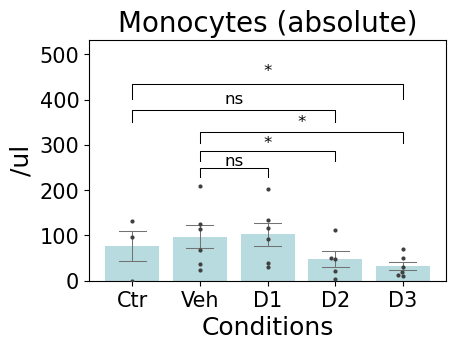

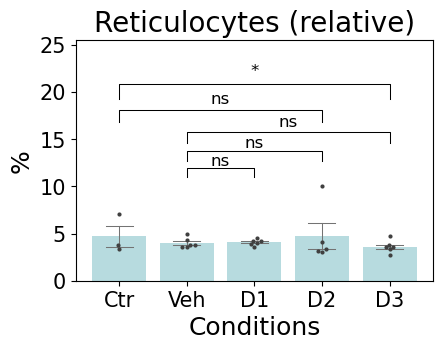

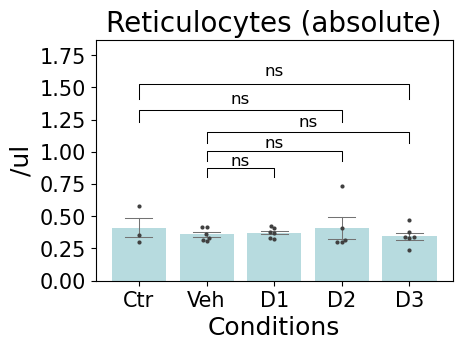

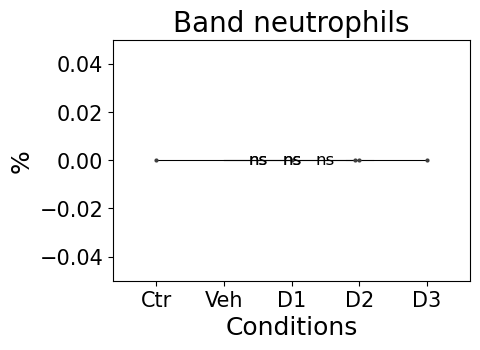

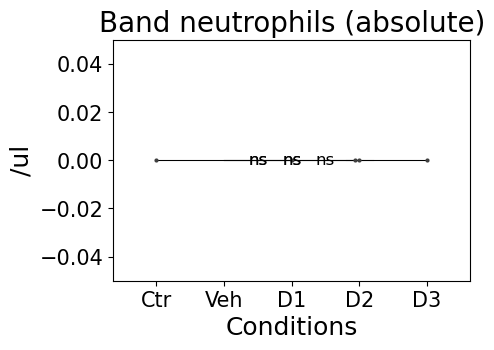

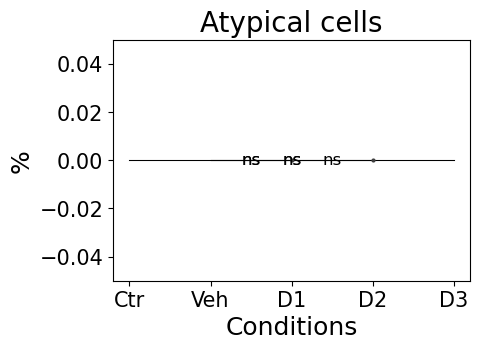

In [16]:
for k,v in datas.items():
    tests = []
    bon_fact = 0
    for c in ['Veh','Ctr']:
        t = ['D1','D2','D3']
        if c == 'Ctr':
            t = t[1:]
        for i in t:
            a = v[v.Conditions == c].Values
            b = v[v.Conditions == i].Values
            tests.append(stats.ttest_ind(a,b)[1])
            bon_fact += 1
    tests = [i/bon_fact for i in tests] # correction for multiple hypothesis testing
    
    fig, ax = plt.subplots(figsize=(4.3,3))
    fig.tight_layout()
    sns.barplot(x='Conditions', y='Values', data=v, errorbar=("ci", 68),
                capsize=.4,err_kws={"color": "0.45", "linewidth": 0.75}, ax=ax, color='#b0e0e6')
    sns.swarmplot(x='Conditions', y='Values', data=v, ax=ax, color='0.25', size=3)
    
    max_val = v.Values.max() + v.Values.max()*0.1
    to = 2
    for num in range(3):
        plt.plot([1,1,to,to], [max_val, max_val+max_val*0.08, max_val+max_val*0.08, max_val], lw=0.75, c='k')
        plt.text((1+to)/2, max_val+max_val*0.15, '*' if tests[num] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
        max_val = max_val + max_val*0.15
        to += 1
    
    to = 3
    for num in range(2):
        plt.plot([0,0,to,to], [max_val, max_val+max_val*0.08, max_val+max_val*0.08, max_val], lw=0.75, c='k')
        plt.text((0+to)/2, max_val+max_val*0.15, '*' if tests[num+3] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
        max_val = max_val + max_val*0.15
        to += 1    

    ax.set_xlabel('Conditions', fontsize=18)
    ax.set_ylabel(v.Unit.unique()[0], fontsize=18)
    ax.set_ylim(0, max_val+max_val*0.15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
    ax.set_title(k, fontsize=20)
    # fig.savefig(f'../plots/{k}.pdf', dpi=300, bbox_inches='tight')

In [17]:
k='Thrombocytes'
v=datas[k]
v.Values.min()

195.0

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/857414863.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/857414863.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/857414863.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/857414863.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=15)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_4613/857414863.py:42: UserWarning: FixedFormatter should only be used

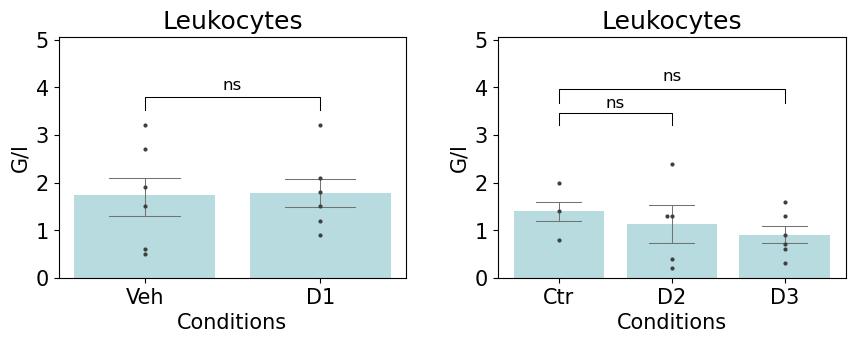

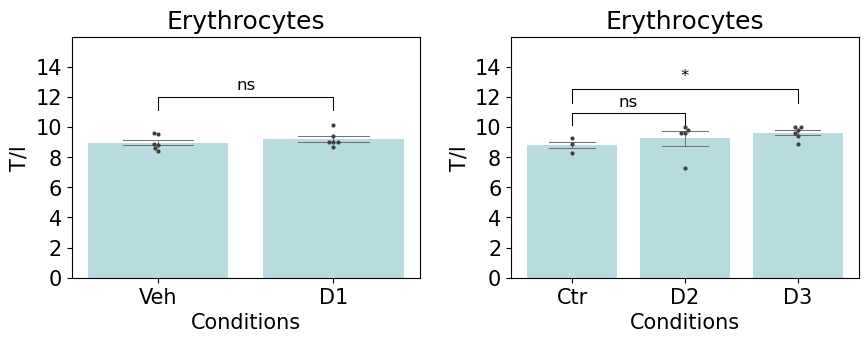

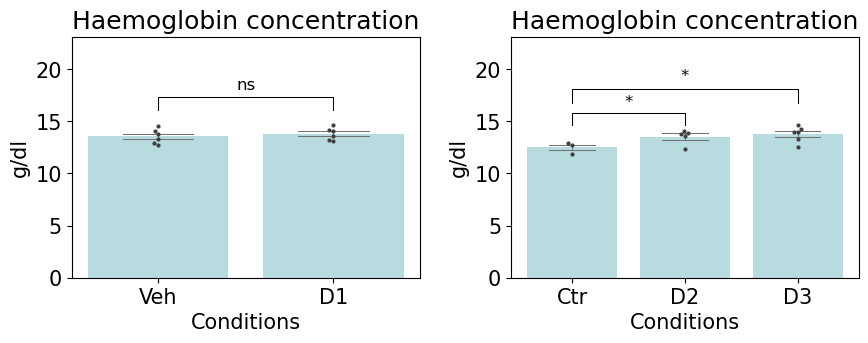

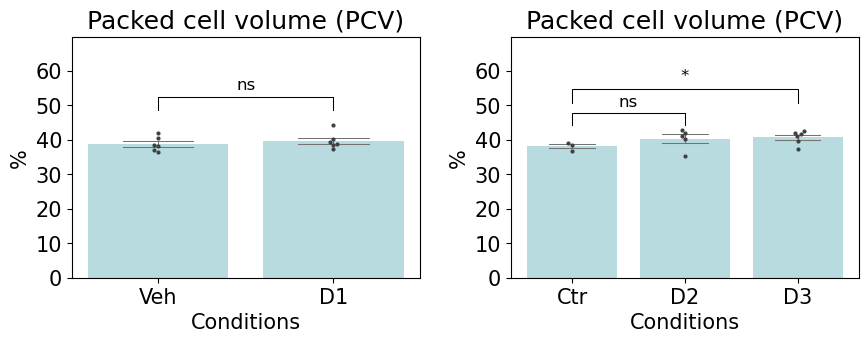

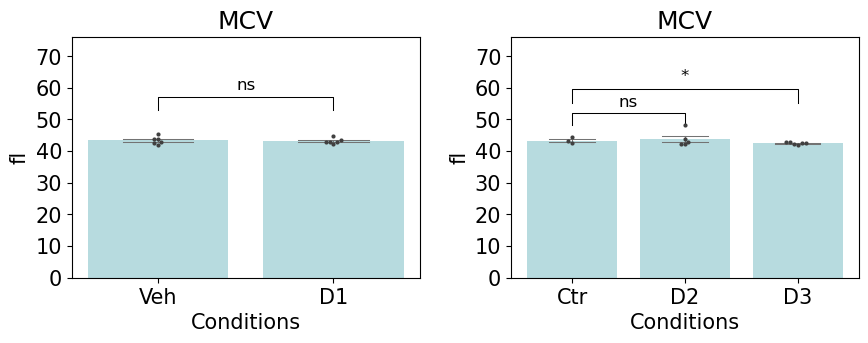

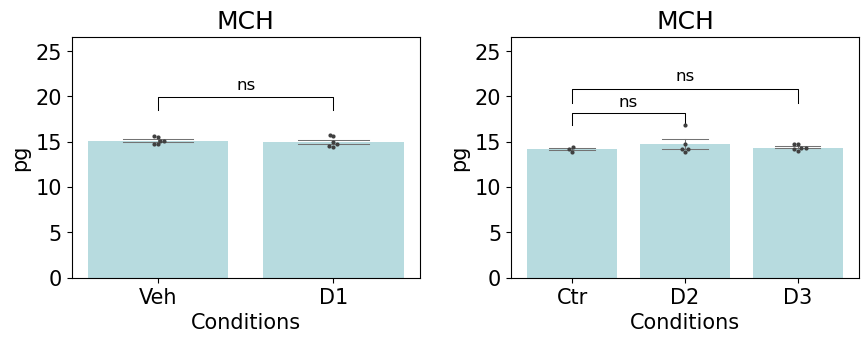

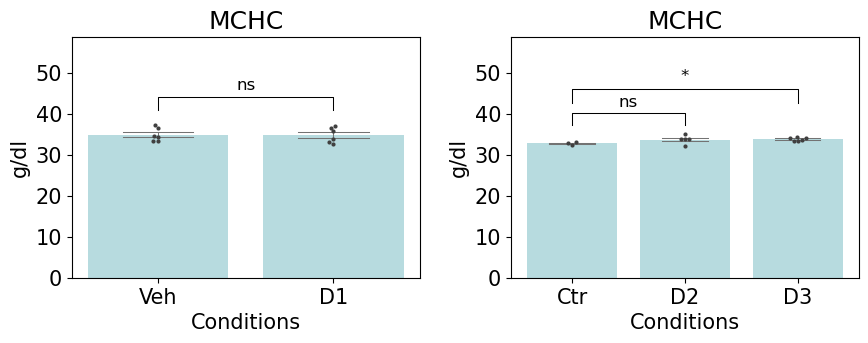

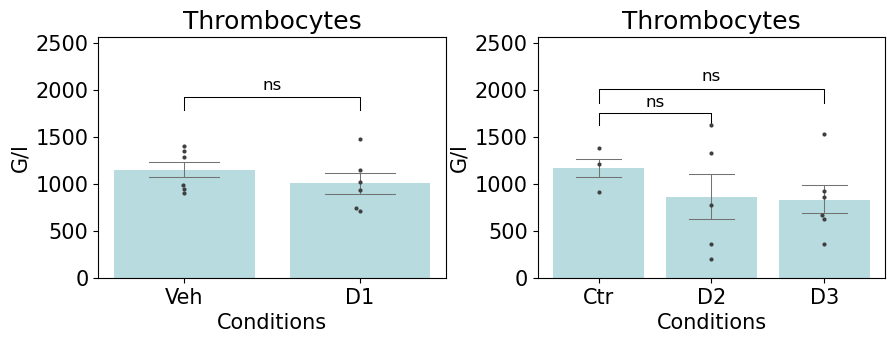

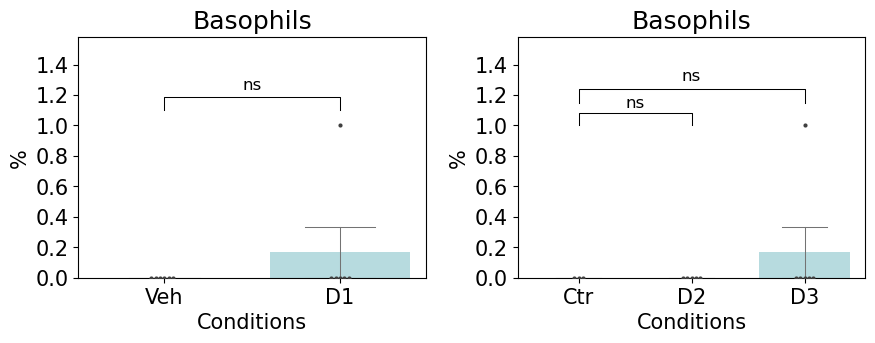

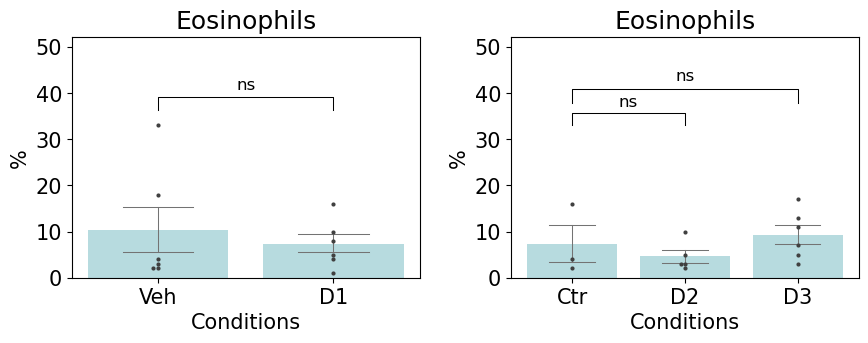

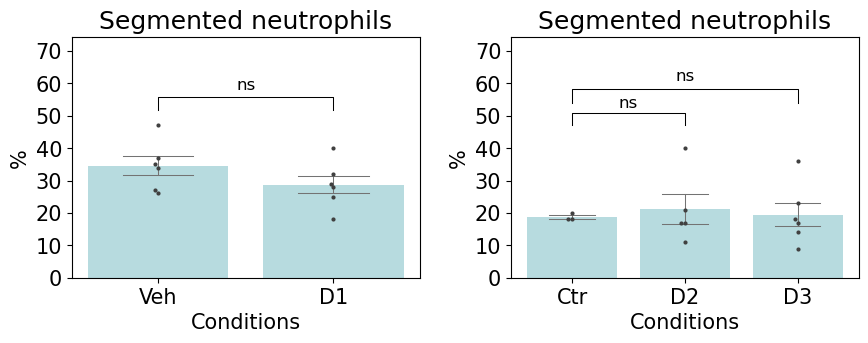

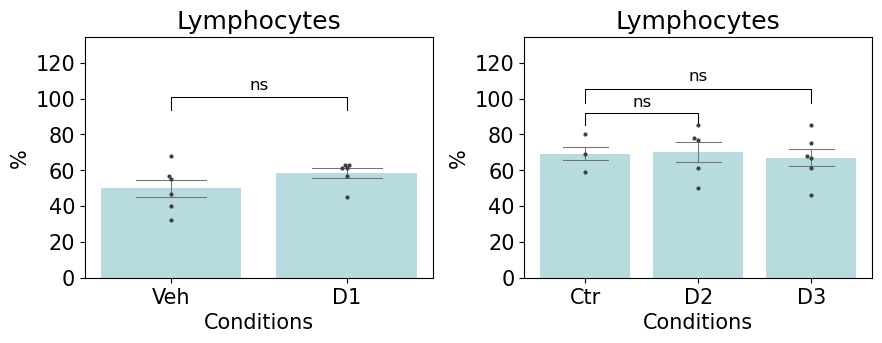

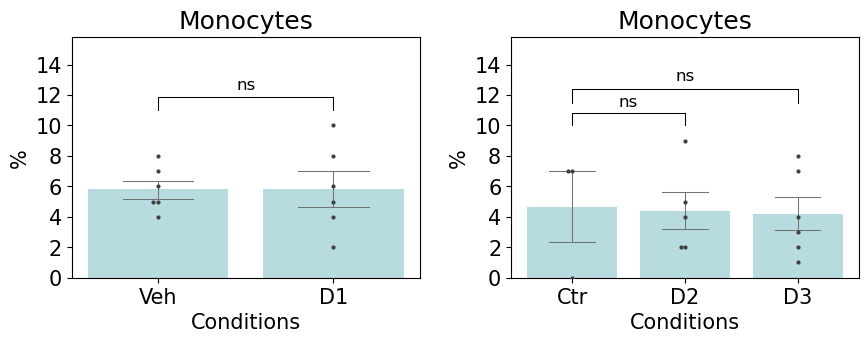

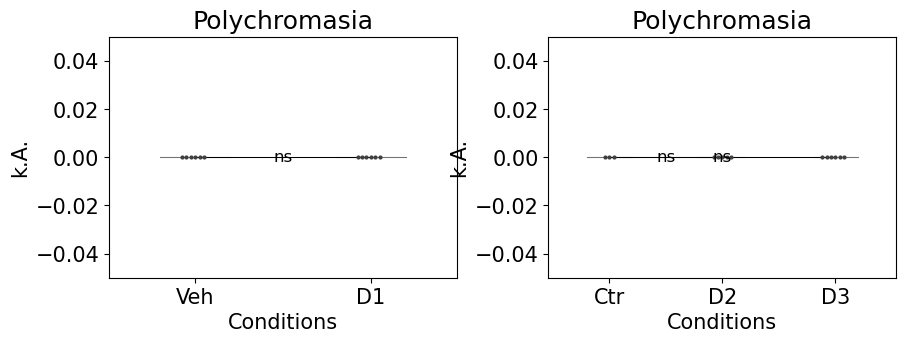

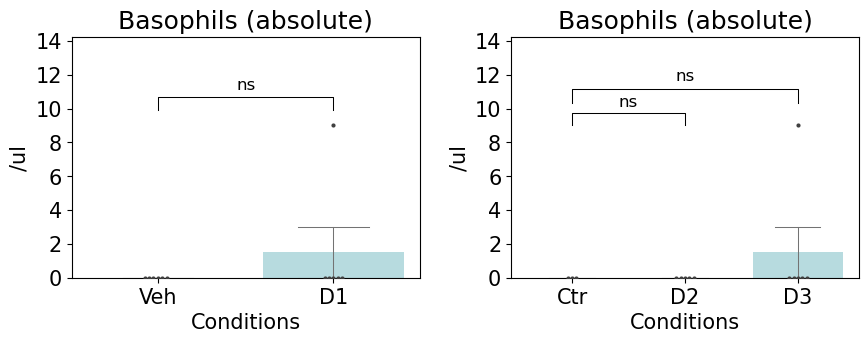

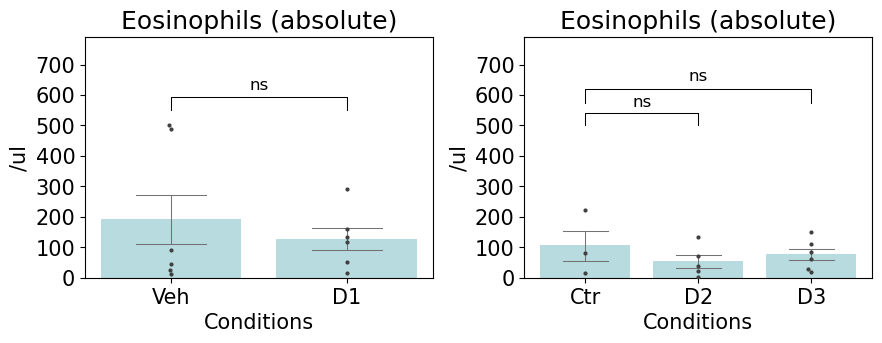

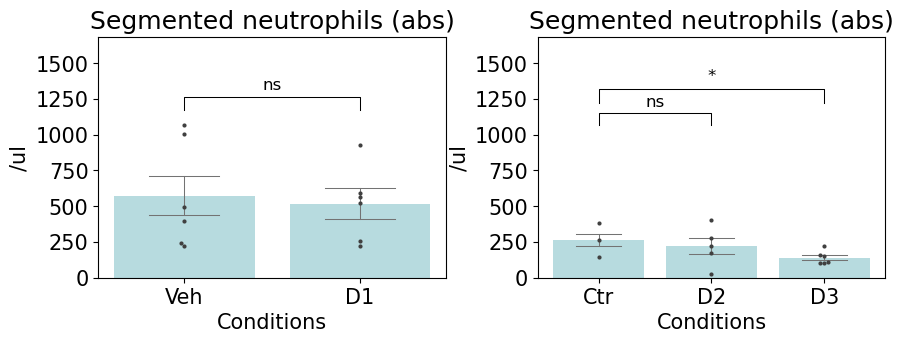

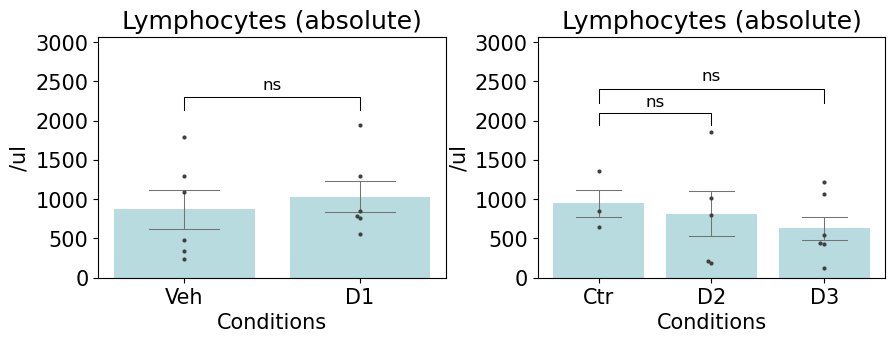

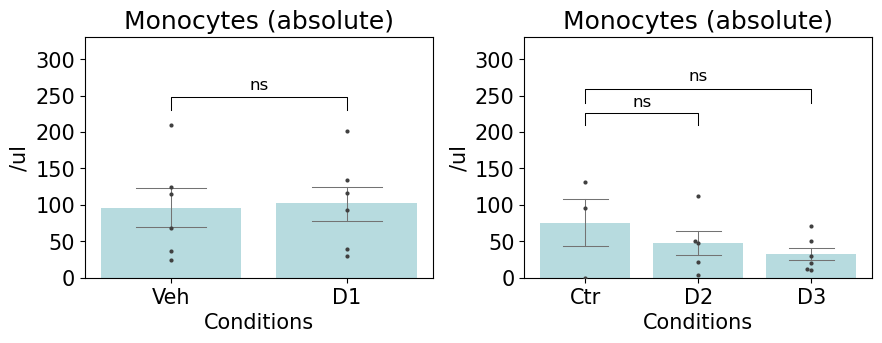

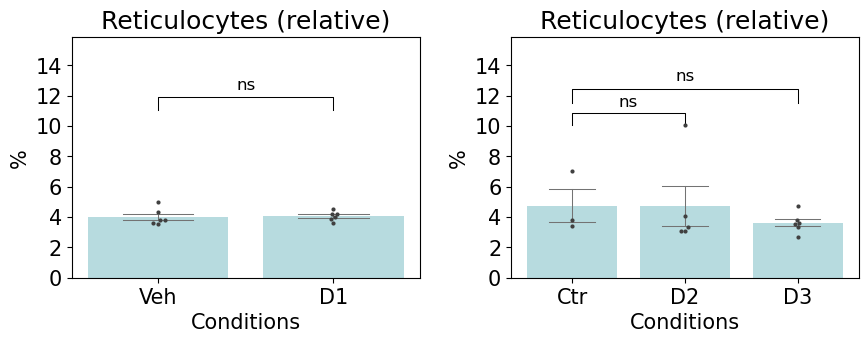

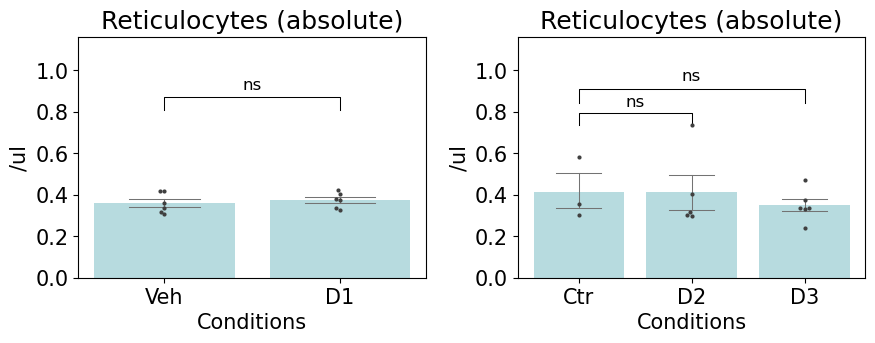

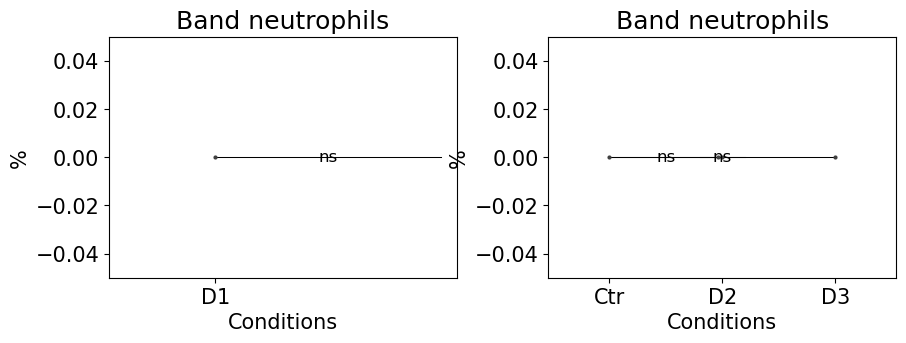

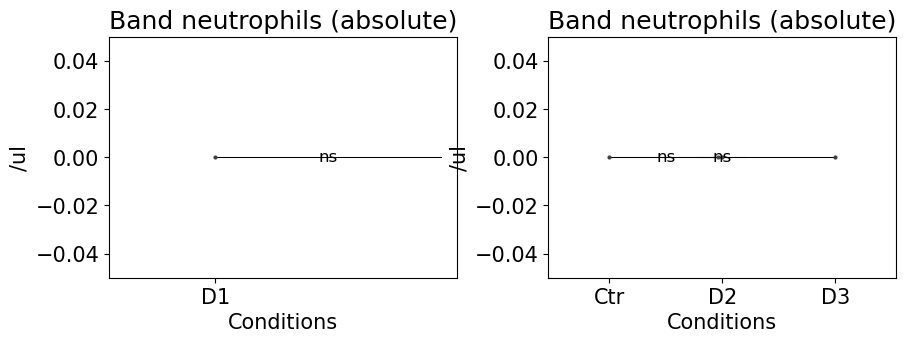

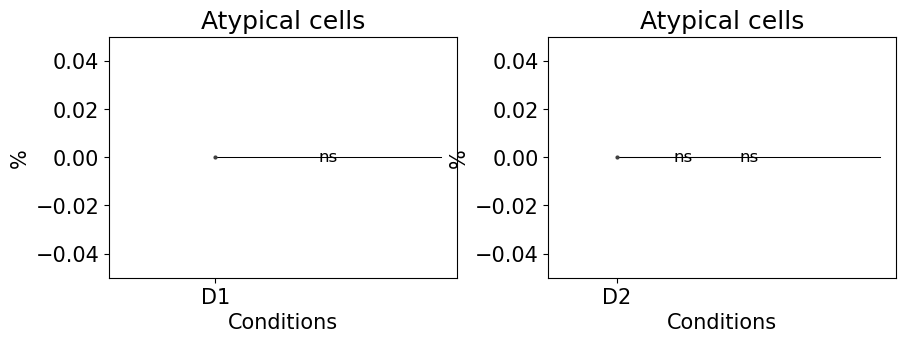

In [18]:
for k,v in datas.items():
    tests = []
    bon_fact = 0
    for c in ['Veh','Ctr']:
        t = ['D1','D2','D3']
        if c == 'Ctr':
            t = t[1:]
        if c == 'Veh':
            t = ['D1']
        for i in t:
            a = v[v.Conditions == c].Values
            b = v[v.Conditions == i].Values
            tests.append(stats.ttest_ind(a,b)[1])
            bon_fact += 1
    tests = [i/bon_fact for i in tests] # correction for multiple hypothesis testing
    
    v_veh = v[v.Conditions.isin(['Veh','D1'])].copy()
    v_veh.Conditions = v_veh.Conditions.cat.remove_unused_categories()
    v_ctr = v[v.Conditions.isin(['Ctr','D2','D3'])].copy()
    v_ctr.Conditions = v_ctr.Conditions.cat.remove_unused_categories()
    fig, ax = plt.subplots(1,2,figsize=(4.3*2,3))
    ax = ax.ravel()
    fig.tight_layout(w_pad=3.5)
    sns.barplot(x='Conditions', y='Values', data=v_veh, errorbar=("ci", 68),
                capsize=.4,err_kws={"color": "0.45", "linewidth": 0.75}, ax=ax[0], color='#b0e0e6')
    sns.swarmplot(x='Conditions', y='Values', data=v_veh, ax=ax[0], color='0.25', size=3)
    
    sns.barplot(x='Conditions', y='Values', data=v_ctr, errorbar=("ci", 68),
                capsize=.4,err_kws={"color": "0.45", "linewidth": 0.75}, ax=ax[1], color='#b0e0e6')
    sns.swarmplot(x='Conditions', y='Values', data=v_ctr, ax=ax[1], color='0.25', size=3)
    
    
    max_val = v.Values.max() + v.Values.max()*0.1
    ax[0].plot([0,0,1,1], [max_val, max_val+max_val*0.08, max_val+max_val*0.08, max_val], lw=0.75, c='k')
    ax[0].text((1)/2, max_val+max_val*0.15, '*' if tests[0] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
    
    max_val = max_val + max_val*0.15
    ylim = max_val+max_val*0.25
    ax[0].set_xlabel('Conditions', fontsize=15)
    ax[0].set_ylabel(v.Unit.unique()[0], fontsize=15)
    ax[0].set_ylim(0, ylim)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=15)
    ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=15)
    ax[0].set_title(k, fontsize=18)
    
    
    max_val = v.Values.max()
    for num in range(2):
        ax[1].plot([0,0,num+1,num+1], [max_val, max_val+max_val*0.08, max_val+max_val*0.08, max_val], lw=0.75, c='k')
        ax[1].text((0+num+1)/2, max_val+max_val*0.15, '*' if tests[num+1] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
        max_val = max_val + max_val*0.15
        
    max_val = max_val + max_val*0.15
    ax[1].set_xlabel('Conditions', fontsize=15)
    ax[1].set_ylabel(v.Unit.unique()[0], fontsize=15)
    ax[1].set_ylim(0, ylim)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=15)
    ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=15)
    ax[1].set_title(k, fontsize=18)  

    # fig.savefig(f'../plots_split/{k}.pdf', dpi=300, bbox_inches='tight')